## Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
import seaborn as sns
from IPython.display import display
import random
import math
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helper_functions import show_images, do_pca, scree_plot, plot_component
from sklearn.cluster import KMeans
import missingno as msno
import seaborn as sns
import visuals as vs
sns.set(font_scale = 2)
%matplotlib inline

/home/rohit/anaconda3/envs/EEG/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Questions and answers 1-6:

1. **Explain your intuition behind the features used for modeling.**

Ans: There are 3 features that can actually be considered numerical features, which are Primary_applicant_age_in_years, Months_loan_taken_for, Principal_loan_amount. All others are either ordinal or categorical features. The target feature is high_risk_applicant, which is a binary feature. Check [this](#handling_cat) cell for furthur information. 

2. **Are you creating new derived features? If yes explain the intuition behind them.**

Ans: Yes, I am converting mixed features mentioned here into numerical features. And i have made a few changes in the mixed feature columns so that we do not have to eliminate rows with nan values. Refer to [this](#mixed_features) cell for more info.  

3. **Are there missing values? If yes how you plan to handle it.**

Ans: I inspected the missing values using a cool library called missingno, it gives a nice visual of all the missing values in the whole data, through bar plots and matrix plots. Refer to [this](#inspecting_missing_values). I [droped columns](#drop_columns) which had more then 30% of the data missing and also [checked the missing values and each row](#checknanrows) but decided not to deleted any data points.

4. **How categorical features are handled for modeling.**

Ans: Explaination for handling categorical features is given [here](#handling_cat) and [here](#onehot) 

5. **Describe the features correlation using correlation matrix. Tell us about few correlated feature & share your understanding on why they are correlated.**

Ans: Refer to [this](#correlation) to see the correlation matrix. We are supposed to remove highly correlated features as they do not bring any new information to the data. 

6. **Do you plan to drop the correlated feature? If yes then how.**

Ans:The most correlated features are principal amount and duration of the loan, the correlation value is 0.62 for both of them, but i have decided to not drop any one of these features, because of two reasons. First, we are not using any linear model like linear regression or GLM that it would be affected by multicollinearity and second, that there is still some amunt of variability that we will loose if we drop any one of the features.

## Load dataset

In [2]:
# Load in the general demographics data.
base_path = './data'
applicant = pd.read_csv(os.path.join(base_path, "applicant.csv"),sep=",")

# Load in the feature summary file.
loan = pd.read_csv(os.path.join(base_path, "loan.csv"), sep=",")


## Overview of data

In [3]:
applicant.head()

,applicant_id,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Has_been_employed_for_at_most,Telephone,Foreign_worker,Savings_account_balance,Balance_in_existing_bank_account_(lower_limit_of_bucket),Balance_in_existing_bank_account_(upper_limit_of_bucket)
0,1469590,67,male,single,1,own,4,skilled employee / official,7 years,NaN,Registered under the applicant's name,1,NaN,NaN,0
1,1203873,22,female,divorced/separated/married,1,own,2,skilled employee / official,1 year,4 years,NaN,1,Low,0,2 lac
2,1432761,49,male,single,2,own,3,unskilled - resident,4 years,7 years,NaN,1,Low,NaN,NaN
3,1207582,45,male,single,2,for free,4,skilled employee / official,4 years,7 years,NaN,1,Low,NaN,0
4,1674436,53,male,single,2,for free,4,skilled employee / official,1 year,4 years,NaN,1,Low,NaN,0


In [4]:
loan.head()

,loan_application_id,applicant_id,Months_loan_taken_for,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Other_EMI_plans,Number_of_existing_loans_at_this_bank,Loan_history,high_risk_applicant
0,d68d975e-edad-11ea-8761-1d6f9c1ff461,1469590,6,electronic equipment,1169000,4,real estate,0,0,NaN,2,critical/pending loans at other banks,0
1,d68d989e-edad-11ea-b1d5-2bcf65006448,1203873,48,electronic equipment,5951000,2,real estate,0,0,NaN,1,existing loans paid back duly till now,1
2,d68d995c-edad-11ea-814a-1b6716782575,1432761,12,education,2096000,2,real estate,0,0,NaN,1,critical/pending loans at other banks,0
3,d68d99fc-edad-11ea-8841-17e8848060ae,1207582,42,FF&E,7882000,2,building society savings agreement/life insurance,0,1,NaN,1,existing loans paid back duly till now,0
4,d68d9a92-edad-11ea-9f3d-1f8682db006a,1674436,24,new vehicle,4870000,3,NaN,0,0,NaN,2,delay in paying off loans in the past,1


## Exploring the numberical features

- This does not say much about anyone of the numerical features but its good to do a manual survey of the features to get an idea of what features might seem correlated to the target variable. 
- Just helps build an intiution about the datset.
- Example, 'Primary_applicant_age_in_years', 'Number_of_dependents' and many more seem to be highly correlated to the target variable just by looking at them.

In [5]:
print("applicant.csv")
display(applicant.describe())
print("loan.csv")
display(loan.describe())

applicant.csv


,applicant_id,Primary_applicant_age_in_years,Number_of_dependents,Years_at_current_residence,Foreign_worker
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.514763e+06,35.546000,1.155000,2.845000,0.963000
std,2.286764e+05,11.375469,0.362086,1.103718,0.188856
min,1.105364e+06,19.000000,1.000000,1.000000,0.000000
25%,1.321398e+06,27.000000,1.000000,2.000000,1.000000
50%,1.529114e+06,33.000000,1.000000,3.000000,1.000000
75%,1.707752e+06,42.000000,1.000000,4.000000,1.000000
max,1.903505e+06,75.000000,2.000000,4.000000,1.000000


loan.csv


,applicant_id,Months_loan_taken_for,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Has_coapplicant,Has_guarantor,Number_of_existing_loans_at_this_bank,high_risk_applicant
count,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.514763e+06,20.903000,3.271258e+06,2.973000,0.041000,0.052000,1.407000,0.300000
std,2.286764e+05,12.058814,2.822737e+06,1.118715,0.198389,0.222138,0.577654,0.458487
min,1.105364e+06,4.000000,2.500000e+05,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.321398e+06,12.000000,1.365500e+06,2.000000,0.000000,0.000000,1.000000,0.000000
50%,1.529114e+06,18.000000,2.319500e+06,3.000000,0.000000,0.000000,1.000000,0.000000
75%,1.707752e+06,24.000000,3.972250e+06,4.000000,0.000000,0.000000,2.000000,1.000000
max,1.903505e+06,72.000000,1.842400e+07,4.000000,1.000000,1.000000,4.000000,1.000000


## Inspecting the datatypes for every columns

- Gives an insight about which columns can be considered as categorical and wont participate in the correlation calculation. The reason is mentioned in this [link](https://stats.stackexchange.com/questions/256344/why-is-correlation-not-very-useful-when-one-of-the-variables-is-categorical)
- And sometimes there are some features that should be numerical features but are in some other datatype, this inspecting can help find such features. example, Balance_in_existing_bank_account_(lower_limit_of_bucket) and Balance_in_existing_bank_account_(upper_limit_of_bucket) seem to fit in this category at first glance.

In [6]:
print("applicant.csv")
display(applicant.dtypes)
print("loan.csv")
display(loan.dtypes)

applicant.csv


applicant_id                                                 int64
Primary_applicant_age_in_years                               int64
Gender                                                      object
Marital_status                                              object
Number_of_dependents                                         int64
Housing                                                     object
Years_at_current_residence                                   int64
Employment_status                                           object
Has_been_employed_for_at_least                              object
Has_been_employed_for_at_most                               object
Telephone                                                   object
Foreign_worker                                               int64
Savings_account_balance                                     object
Balance_in_existing_bank_account_(lower_limit_of_bucket)    object
Balance_in_existing_bank_account_(upper_limit_of_bucket)    ob

loan.csv


loan_application_id                            object
applicant_id                                    int64
Months_loan_taken_for                           int64
Purpose                                        object
Principal_loan_amount                           int64
EMI_rate_in_percentage_of_disposable_income     int64
Property                                       object
Has_coapplicant                                 int64
Has_guarantor                                   int64
Other_EMI_plans                                object
Number_of_existing_loans_at_this_bank           int64
Loan_history                                   object
high_risk_applicant                             int64
dtype: object

## Inspecting the number of missing values for each column
<a id='inspecting_missing_values'></a>

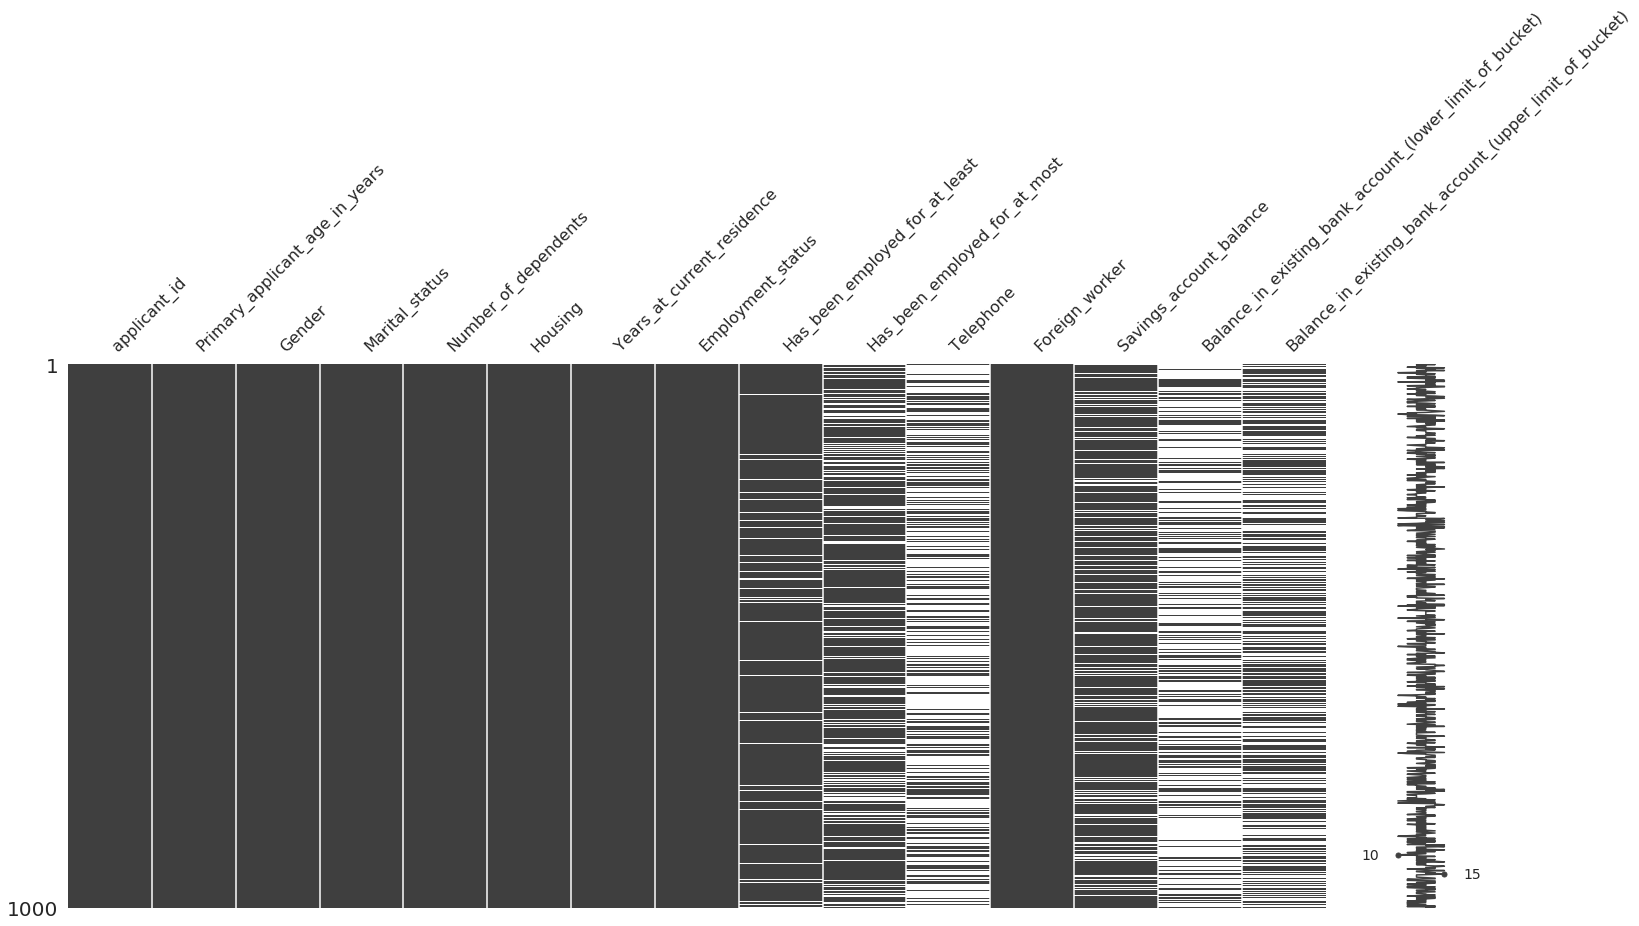

In [7]:
msno.matrix(applicant)

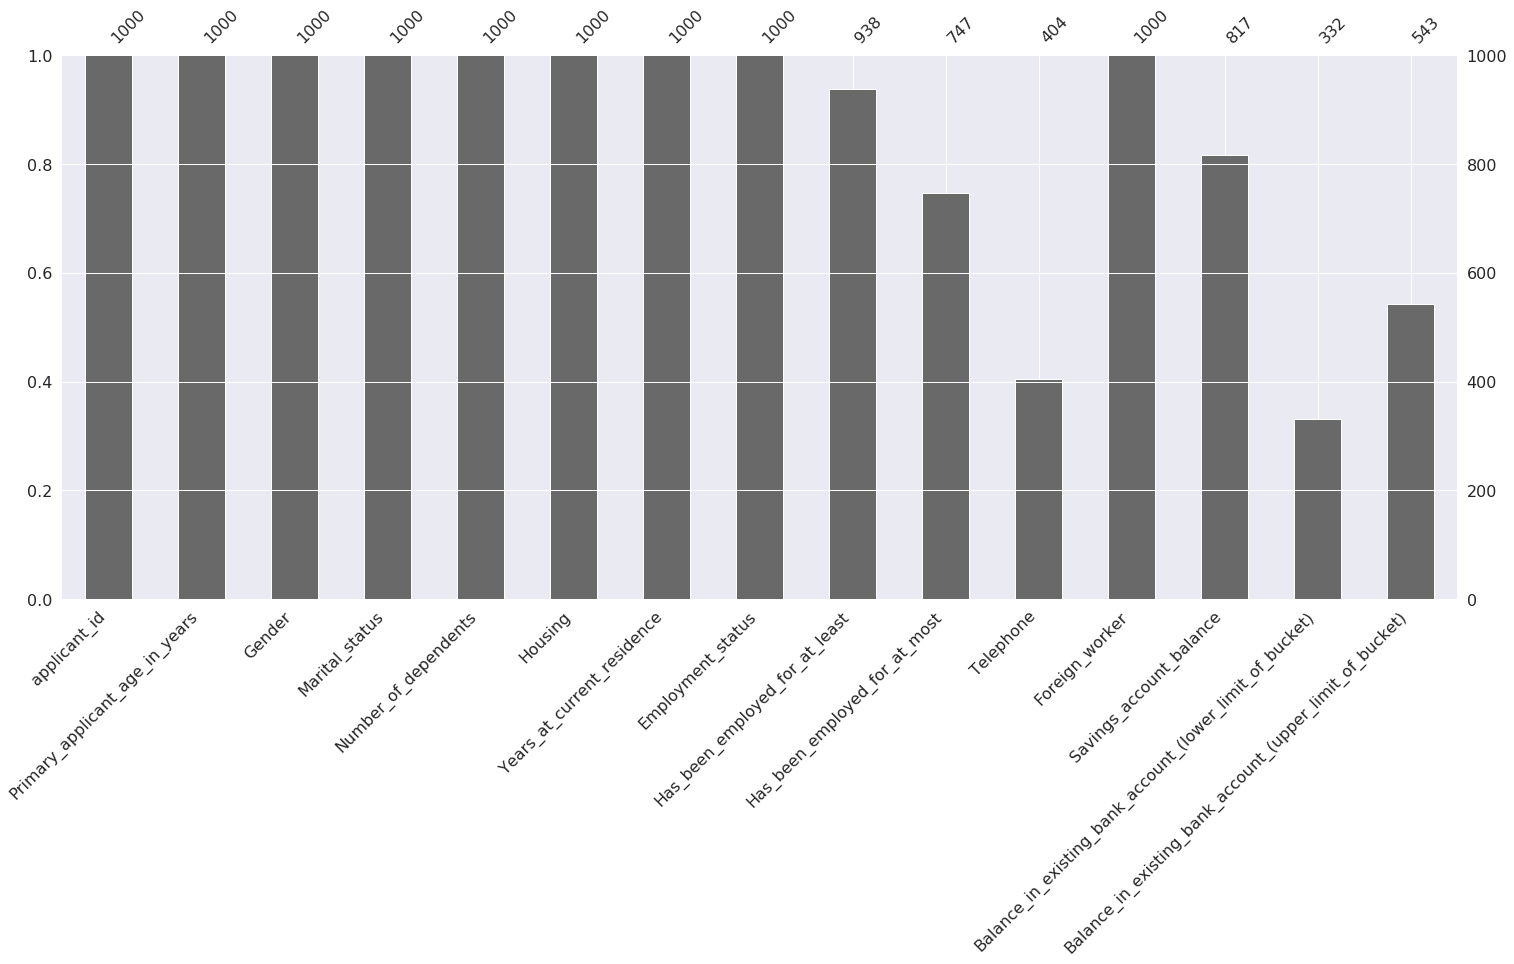

In [8]:
msno.bar(applicant)

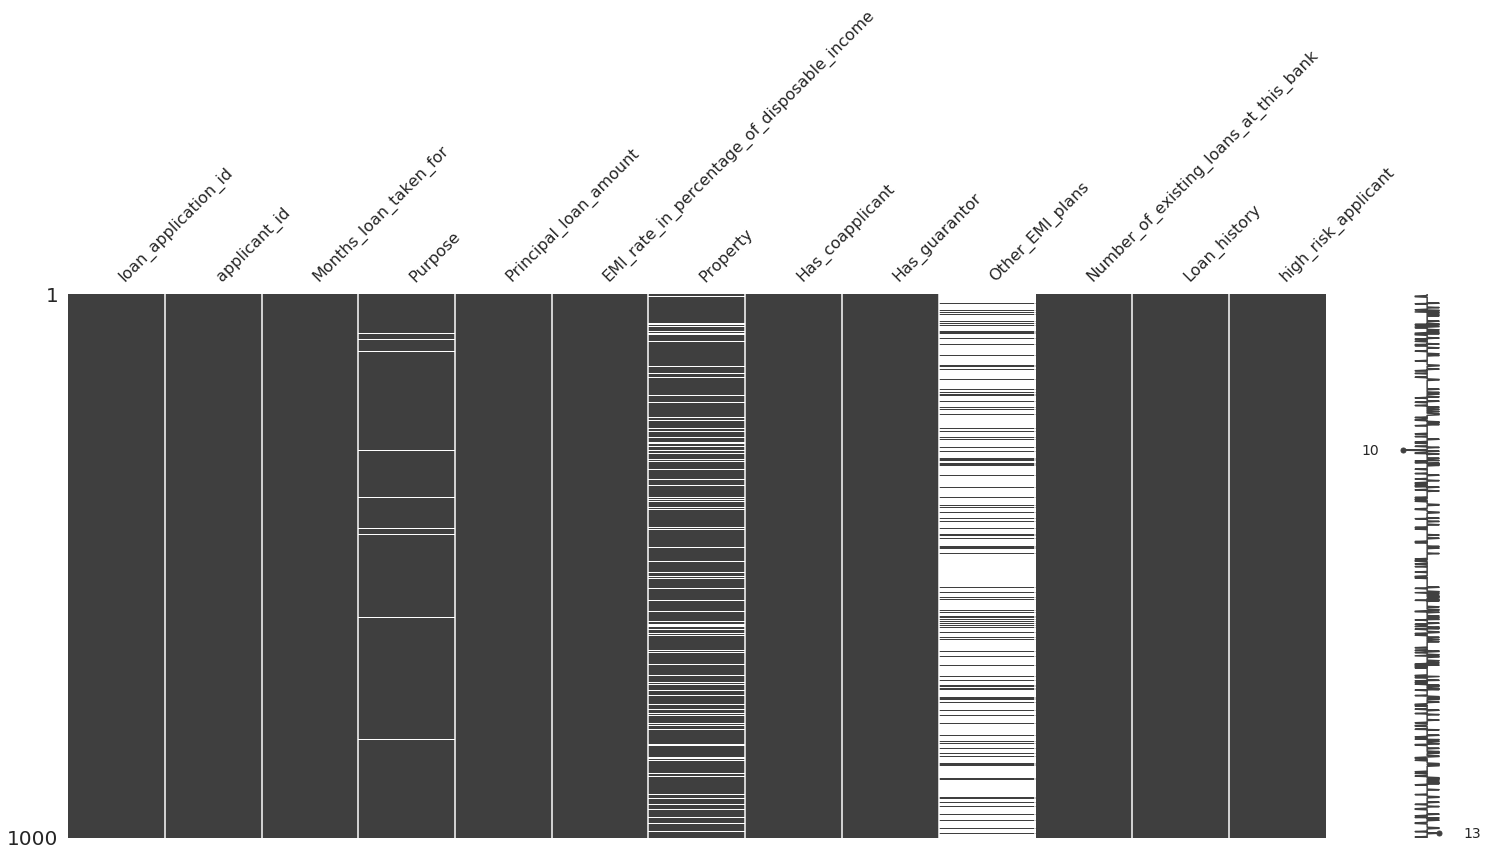

In [9]:
msno.matrix(loan)

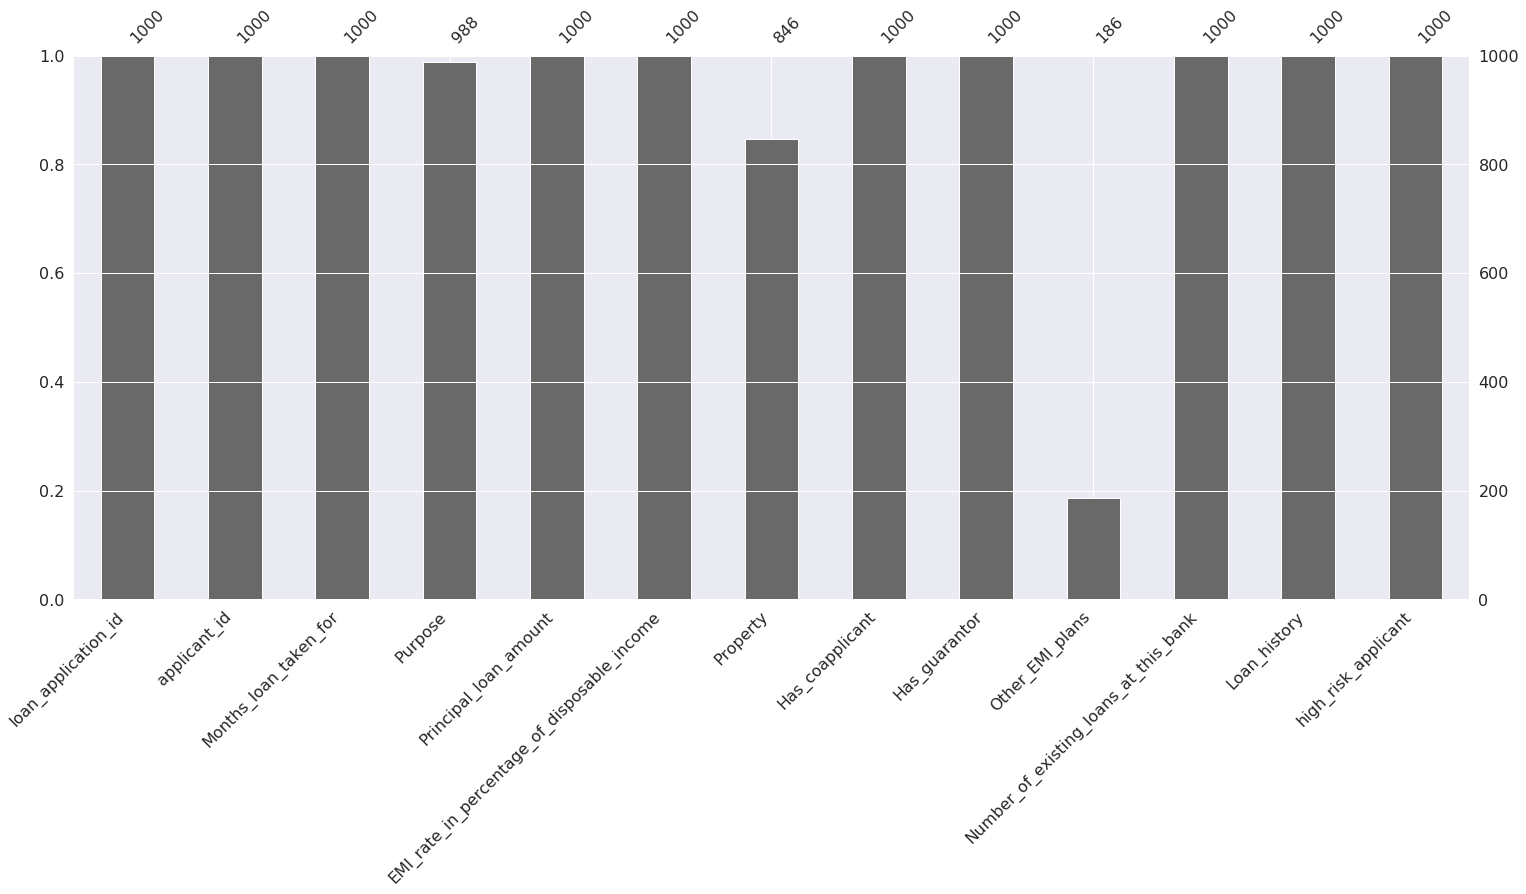

In [10]:
msno.bar(loan)

### Getting columns with most number of missing values

In [11]:
applicant_nan = applicant.isna().sum().to_frame('nans').sort_values(by='nans',ascending=False)
applicant_nan

,nans
Balance_in_existing_bank_account_(lower_limit_of_bucket),668
Telephone,596
Balance_in_existing_bank_account_(upper_limit_of_bucket),457
Has_been_employed_for_at_most,253
Savings_account_balance,183
Has_been_employed_for_at_least,62
applicant_id,0
Primary_applicant_age_in_years,0
Gender,0
Marital_status,0


In [12]:
loan_nan = loan.isna().sum().to_frame('nans').sort_values(by='nans',ascending=False)
loan_nan

,nans
Other_EMI_plans,814
Property,154
Purpose,12
loan_application_id,0
applicant_id,0
Months_loan_taken_for,0
Principal_loan_amount,0
EMI_rate_in_percentage_of_disposable_income,0
Has_coapplicant,0
Has_guarantor,0


## merge the two dataframes

1. Check if applicant_id can be a primary key in one dataframe and foreign key in another.
2. Actually merge the dataframes

From below we can see that applicant_id seems like a good fit and we can merge the two datasets using the feature.

In [13]:
print(applicant.shape, loan.shape)

(1000, 15) (1000, 13)


In [14]:
(applicant.applicant_id == loan.applicant_id).sum()

1000

In [15]:
applicant_loan = pd.merge(applicant, loan, left_on = 'applicant_id', right_on = 'applicant_id')

### Congruency checks and asserts for the resultant dataset

In [16]:
applicant_loan.head(10)

,applicant_id,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Has_been_employed_for_at_most,...,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Other_EMI_plans,Number_of_existing_loans_at_this_bank,Loan_history,high_risk_applicant
0,1469590,67,male,single,1,own,4,skilled employee / official,7 years,NaN,...,electronic equipment,1169000,4,real estate,0,0,NaN,2,critical/pending loans at other banks,0
1,1203873,22,female,divorced/separated/married,1,own,2,skilled employee / official,1 year,4 years,...,electronic equipment,5951000,2,real estate,0,0,NaN,1,existing loans paid back duly till now,1
2,1432761,49,male,single,2,own,3,unskilled - resident,4 years,7 years,...,education,2096000,2,real estate,0,0,NaN,1,critical/pending loans at other banks,0
3,1207582,45,male,single,2,for free,4,skilled employee / official,4 years,7 years,...,FF&E,7882000,2,building society savings agreement/life insurance,0,1,NaN,1,existing loans paid back duly till now,0
4,1674436,53,male,single,2,for free,4,skilled employee / official,1 year,4 years,...,new vehicle,4870000,3,NaN,0,0,NaN,2,delay in paying off loans in the past,1
5,1213971,35,male,single,2,for free,4,unskilled - resident,1 year,4 years,...,education,9055000,2,NaN,0,0,NaN,1,existing loans paid back duly till now,0
6,1428822,53,male,single,1,own,4,skilled employee / official,7 years,NaN,...,FF&E,2835000,3,building society savings agreement/life insurance,0,0,NaN,1,existing loans paid back duly till now,0
7,1705739,35,male,single,1,rent,2,management / self-employed / highly qualified ...,1 year,4 years,...,used vehicle,6948000,2,car or other,0,0,NaN,1,existing loans paid back duly till now,0
8,1715169,61,male,divorced/separated,1,own,4,unskilled - resident,4 years,7 years,...,electronic equipment,3059000,2,real estate,0,0,NaN,1,existing loans paid back duly till now,0
9,1722991,28,male,married/widowed,1,own,2,management / self-employed / highly qualified ...,NaN,0 year,...,new vehicle,5234000,4,car or other,0,0,NaN,2,critical/pending loans at other banks,1


In [17]:
assert(applicant_loan.shape[0] == applicant.shape[0])
assert(applicant_loan.shape[1] == applicant.shape[1] + loan.shape[1] - 1)

## Check the number of missing values in each column of the resultant dataframe
<a id='drop_columns'></a>

In [18]:
applicant_loan_nan = applicant_loan.isna().sum().to_frame('nans').sort_values(by='nans',ascending=False)

In [19]:
applicant_loan_nan['nans'] = (applicant_loan_nan['nans']/applicant_loan.shape[0])
applicant_loan_nan

,nans
Other_EMI_plans,0.814
Balance_in_existing_bank_account_(lower_limit_of_bucket),0.668
Telephone,0.596
Balance_in_existing_bank_account_(upper_limit_of_bucket),0.457
Has_been_employed_for_at_most,0.253
Savings_account_balance,0.183
Property,0.154
Has_been_employed_for_at_least,0.062
Purpose,0.012
Months_loan_taken_for,0.000


### Drop columns

- **drop columns applicant_id and loan_application_id as all values in them are unique and the model can directly learn which applicant_id gives a certain value for target variable**

- **drop columns with more then 30% of the values in the column are missing or have nan**

In [20]:
drop_columns = list(applicant_loan_nan[applicant_loan_nan['nans']>0.3].index)
drop_columns.extend(['applicant_id', 'loan_application_id'])
print(applicant_loan.shape)
applicant_loan_v1 = applicant_loan.drop(drop_columns, axis='columns')
print(drop_columns)
print(applicant_loan.shape)
print(applicant_loan_v1.shape)

(1000, 27)
['Other_EMI_plans', 'Balance_in_existing_bank_account_(lower_limit_of_bucket)', 'Telephone', 'Balance_in_existing_bank_account_(upper_limit_of_bucket)', 'applicant_id', 'loan_application_id']
(1000, 27)
(1000, 21)


## Check the number of missing values in rows of the resultant dataframe
<a id='checknanrows'></a>

- As this analysis shows that atmost 4 missing values out of 21 are possible in a row.
- We can elminate the rows that have missing values greater then a certain threshold or divide the data into two subsets and compare the distribution of the columns for those subsets, but since the data is only 1000 rows we can't afford to do either.
- Its better that we just handle the missing values without eliminating any rows. 
- But before that we need to understand each column individually and handle categorical and mixed datatype columns properly.

In [21]:
missing_val_row = pd.DataFrame(applicant_loan_v1.isnull().sum(axis=1),columns=['missing_values'])
missing_val_row['temp'] = 1
missing_val_row.groupby(['missing_values']).sum().sort_values(ascending=False, by = 'temp')

,temp
missing_values,
0,518
1,324
2,135
3,22
4,1


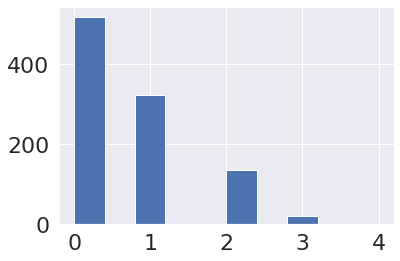

In [22]:
applicant_loan_v1.isnull().sum(axis=1).hist()

In [23]:
(135+22+1)/1000

0.158

## Check unique values for each column

In [24]:
temp_dtype=applicant_loan_v1.dtypes.to_frame('dtype').reset_index()
temp_dtype[temp_dtype['dtype']=='int64']

,index,dtype
0,Primary_applicant_age_in_years,int64
3,Number_of_dependents,int64
5,Years_at_current_residence,int64
9,Foreign_worker,int64
11,Months_loan_taken_for,int64
13,Principal_loan_amount,int64
14,EMI_rate_in_percentage_of_disposable_income,int64
16,Has_coapplicant,int64
17,Has_guarantor,int64
18,Number_of_existing_loans_at_this_bank,int64


In [25]:
print("object:")
for col in temp_dtype[temp_dtype['dtype']==object]['index']:
    print(col,'::::::::::',applicant_loan_v1[col].nunique(),applicant_loan_v1[col].unique())
print("in64:")
for col in temp_dtype[temp_dtype['dtype']=='int64']['index']:
    if applicant_loan_v1[col].nunique() <= 10:
        print(col,'::::::::::',applicant_loan_v1[col].nunique(), applicant_loan_v1[col].unique())
    else:
        print(col,'::::::::::',applicant_loan_v1[col].nunique())

object:
Gender :::::::::: 2 ['male' 'female']
Marital_status :::::::::: 4 ['single' 'divorced/separated/married' 'divorced/separated'
 'married/widowed']
Housing :::::::::: 3 ['own' 'for free' 'rent']
Employment_status :::::::::: 4 ['skilled employee / official' 'unskilled - resident'
 'management / self-employed / highly qualified employee / officer'
 'unemployed / unskilled - non-resident']
Has_been_employed_for_at_least :::::::::: 4 ['7 years' '1 year' '4 years' nan '0 year']
Has_been_employed_for_at_most :::::::::: 4 [nan '4 years' '7 years' '0 year' '1 year']
Savings_account_balance :::::::::: 4 [nan 'Low' 'High' 'Very high' 'Medium']
Purpose :::::::::: 9 ['electronic equipment' 'education' 'FF&E' 'new vehicle' 'used vehicle'
 'business' 'domestic appliances' 'repair costs' nan 'career development']
Property :::::::::: 3 ['real estate' 'building society savings agreement/life insurance' nan
 'car or other']
Loan_history :::::::::: 5 ['critical/pending loans at other banks'
 'exist

## Handle categorical, mixed type features
<a id='handling_cat'></a>

First we have to sort the features into these categories:
- Categorical and binary
- mixed type
- Numerical

This division should be done carefully. 
- The main point to remember to sort a feature as categorical is that the values cannot be intrinsically ordered between themselves. 
- And even though some features seem that they can be sorted as categorical because they have limited values but they cannot because each of the values have a specific weight to them(ordinal features), hence must be sorted as numerical features.
- I have put a third category over here, which is mixed features, as they would fit good as both numerical or categorical,i prefered that these features would be helpful if they are converted into numerical features as values in 'Has_been_employed_for_at_least','Has_been_employed_for_at_most' are number of years of experience and that can be any number not just 1, 4 or 7.
- Apart from that some categorical features have nan values in them, but i feel here nan values might not denote missing values, but can also be treated as another category in the feature and might be helpful in making better decision, after all the data is pretty small and each and every bit of information is useful.

In [26]:
categorical_feature=['Marital_status','Housing', 'Employment_status','Savings_account_balance','Purpose','Property','Loan_history','Foreign_worker', 'Has_coapplicant','Has_guarantor','Gender']
target_features = ['high_risk_applicant']
mixed_features = ['Has_been_employed_for_at_least','Has_been_employed_for_at_most']
numerical_features = ['Primary_applicant_age_in_years','Number_of_dependents', 'Years_at_current_residence', 'Months_loan_taken_for', 'Principal_loan_amount','EMI_rate_in_percentage_of_disposable_income', 'Number_of_existing_loans_at_this_bank']

#### Convert the mixed feature to numerical features
<a id='mixed_features'></a>
mixed_features = ['Has_been_employed_for_at_least','Has_been_employed_for_at_most']

Here there are few point to be noted.
- I feel that these columns should not be as categorical as the number of years should have some numerical weight to it and would aid the model more in classifying the applicant.
- These two mixed features have nan values but there is a pattern to it. There is a nan value in 'Has_been_employed_for_at_least' when the feature 'Has_been_employed_for_at_most' has the value '0 years' and similarly the feature 'Has_been_employed_for_at_most' has a nan value when 'Has_been_employed_for_at_least' has the value '7 years'. I feel there is no harm in eliminating the nan values by replacing them with the same value as in the other feature.

In [27]:
applicant_loan_v1[mixed_features].iloc[:30]

,Has_been_employed_for_at_least,Has_been_employed_for_at_most
0,7 years,NaN
1,1 year,4 years
2,4 years,7 years
3,4 years,7 years
4,1 year,4 years
5,1 year,4 years
6,7 years,NaN
7,1 year,4 years
8,4 years,7 years
9,NaN,0 year


In [28]:
# Fill nan 
applicant_loan_v1[mixed_features[0]] = [applicant_loan_v1[mixed_features[1]].iloc[n] if str(i) == 'nan' else i for n,i in enumerate(applicant_loan_v1[mixed_features[0]])]
applicant_loan_v1[mixed_features[1]] = [applicant_loan_v1[mixed_features[0]].iloc[n] if str(i) == 'nan' else i for n,i in enumerate(applicant_loan_v1[mixed_features[1]])]

# Convert the mixed feature to numerical features
applicant_loan_v1[mixed_features[0]] = [str(i)[0] for i in applicant_loan_v1[mixed_features[0]]]
applicant_loan_v1[mixed_features[1]] = [str(i)[0] for i in applicant_loan_v1[mixed_features[1]]]

applicant_loan_v1[mixed_features]

,Has_been_employed_for_at_least,Has_been_employed_for_at_most
0,7,7
1,1,4
2,4,7
3,4,7
4,1,4
...,...,...
995,4,7
996,1,4
997,7,7
998,1,4


### Get the one hot encoding for categorical features
<a id='onehot'></a>
- The nan values are present in the categorical features, instead of eliminating those row, there is a high chance that the nan values might represent a certain population in the data, and we might loose to represent those group if we eliminate those data points, so its better to treat those nan values as a separate category.

In [29]:
applicant_loan_v2 = pd.get_dummies(applicant_loan_v1, dummy_na=True, columns = categorical_feature)

In [30]:
applicant_loan_v2.shape

(1000, 61)

### As you can see there are no nan values in the resultant dataset.

In [31]:
applicant_loan_v2.isna().sum().to_frame('nans').sort_values(by='nans',ascending=False).sum()

nans    0
dtype: int64

# Feature transformation:

Apply feature scaling to the data.

There is one point which we need to give thought to:

Does it make sense to apply transformation to one hot encoded features?
I believe it does not, as One-hot encoding implies the level of the measurement for a feature is nominal / categorial. Standardization implies the level of measure for a features is at least interval. 

Example, if the feature is country of origin. Since that feature is categorical, one-hot encoding makes sense. A person is from a country or not. Taking the mean of the country of origin yields numbers that do not make sense.

So i will only apply feature transformation on variables that are not categorical or binary features.

Reference: [Link](https://datascience.stackexchange.com/questions/80234/possible-harm-in-standardizing-one-hot-encoded-features)

## Inspecting the distribution of numerical feature

It is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.

And as we can see from below these three features are highly skewed.

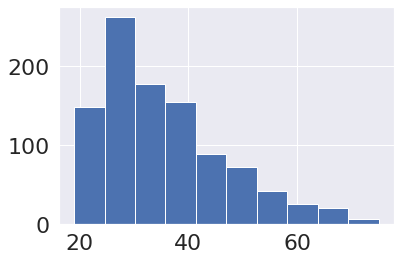

In [32]:
applicant_loan_v1['Primary_applicant_age_in_years'].hist()

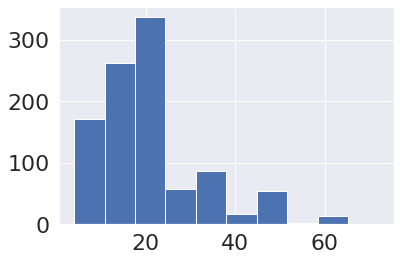

In [33]:
applicant_loan_v1['Months_loan_taken_for'].hist()

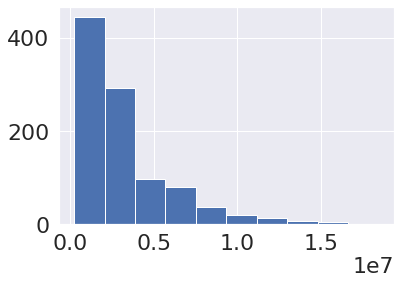

In [34]:
applicant_loan_v1['Principal_loan_amount'].hist()

## Log-transform the skewed features

In [35]:
skewed = ['Principal_loan_amount', 'Months_loan_taken_for', 'Primary_applicant_age_in_years']
applicant_loan_v1[skewed] = applicant_loan_v1[skewed].apply(lambda x: np.log(x + 1))

## Visualize the new log distributions

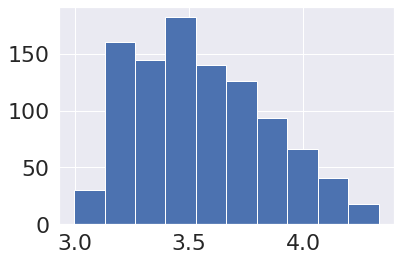

In [36]:
applicant_loan_v1['Primary_applicant_age_in_years'].hist()

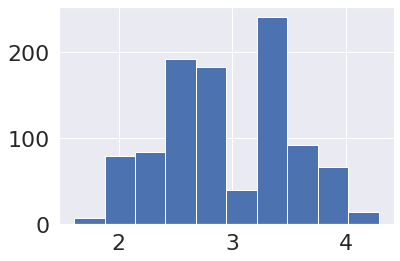

In [37]:
applicant_loan_v1['Months_loan_taken_for'].hist()

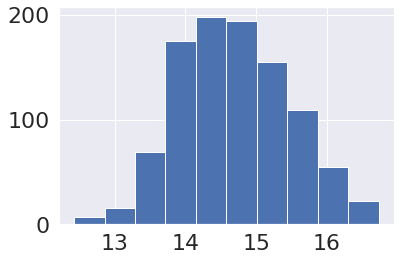

In [38]:
applicant_loan_v1['Principal_loan_amount'].hist()

## Now standardizing the numerical features

In [39]:
scaler = StandardScaler()
features_transform = numerical_features
applicant_loan_v2[features_transform] = scaler.fit_transform(applicant_loan_v2[features_transform])
applicant_loan_v2.head()

,Primary_applicant_age_in_years,Number_of_dependents,Years_at_current_residence,Has_been_employed_for_at_least,Has_been_employed_for_at_most,Months_loan_taken_for,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Number_of_existing_loans_at_this_bank,high_risk_applicant,...,Foreign_worker_nan,Has_coapplicant_0.0,Has_coapplicant_1.0,Has_coapplicant_nan,Has_guarantor_0.0,Has_guarantor_1.0,Has_guarantor_nan,Gender_female,Gender_male,Gender_nan
0,2.766456,-0.428290,1.046987,7,7,-1.236478,-0.745131,0.918477,1.027079,0,...,0,1,0,0,1,0,0,0,1,0
1,-1.191404,-0.428290,-0.765977,1,4,2.248194,0.949817,-0.870183,-0.704926,1,...,0,1,0,0,1,0,0,1,0,0
2,1.183312,2.334869,0.140505,4,7,-0.738668,-0.416562,-0.870183,-0.704926,0,...,0,1,0,0,1,0,0,0,1,0
3,0.831502,2.334869,1.046987,4,7,1.750384,1.634247,-0.870183,-0.704926,0,...,0,1,0,0,0,1,0,0,1,0
4,1.535122,2.334869,1.046987,1,4,0.256953,0.566664,0.024147,1.027079,1,...,0,1,0,0,1,0,0,0,1,0


In [40]:
applicant_loan_v2.shape

(1000, 61)

In [41]:
applicant_risk = applicant_loan_v2['high_risk_applicant']
applicant_loan_v3 = applicant_loan_v2.drop(['high_risk_applicant'], axis='columns')

## Correlation between features
<a id='correlation'></a>
Observations are as follows:

- applicant id's are useless, they are unique and are barely related to any other feature.
- Primary applicant age is positively correlated to numer of dependents, years at current residence and number of existing loans at the bank, which makes sense since older the person more are the chances of them having more childrens, living at the same house and having multiple loans at the same bank.
- duration of loan is strongly correlated to principal amount for the loan, higher the amount longer the duration to pay back the loan.
- Principal loan amount is negatively correlated to the EMI percent, as lager the amount lesser the EMI percent the applicant has to give.
- the target variable is directly correlated to duration of the loan, principal amount and EMI rate. 

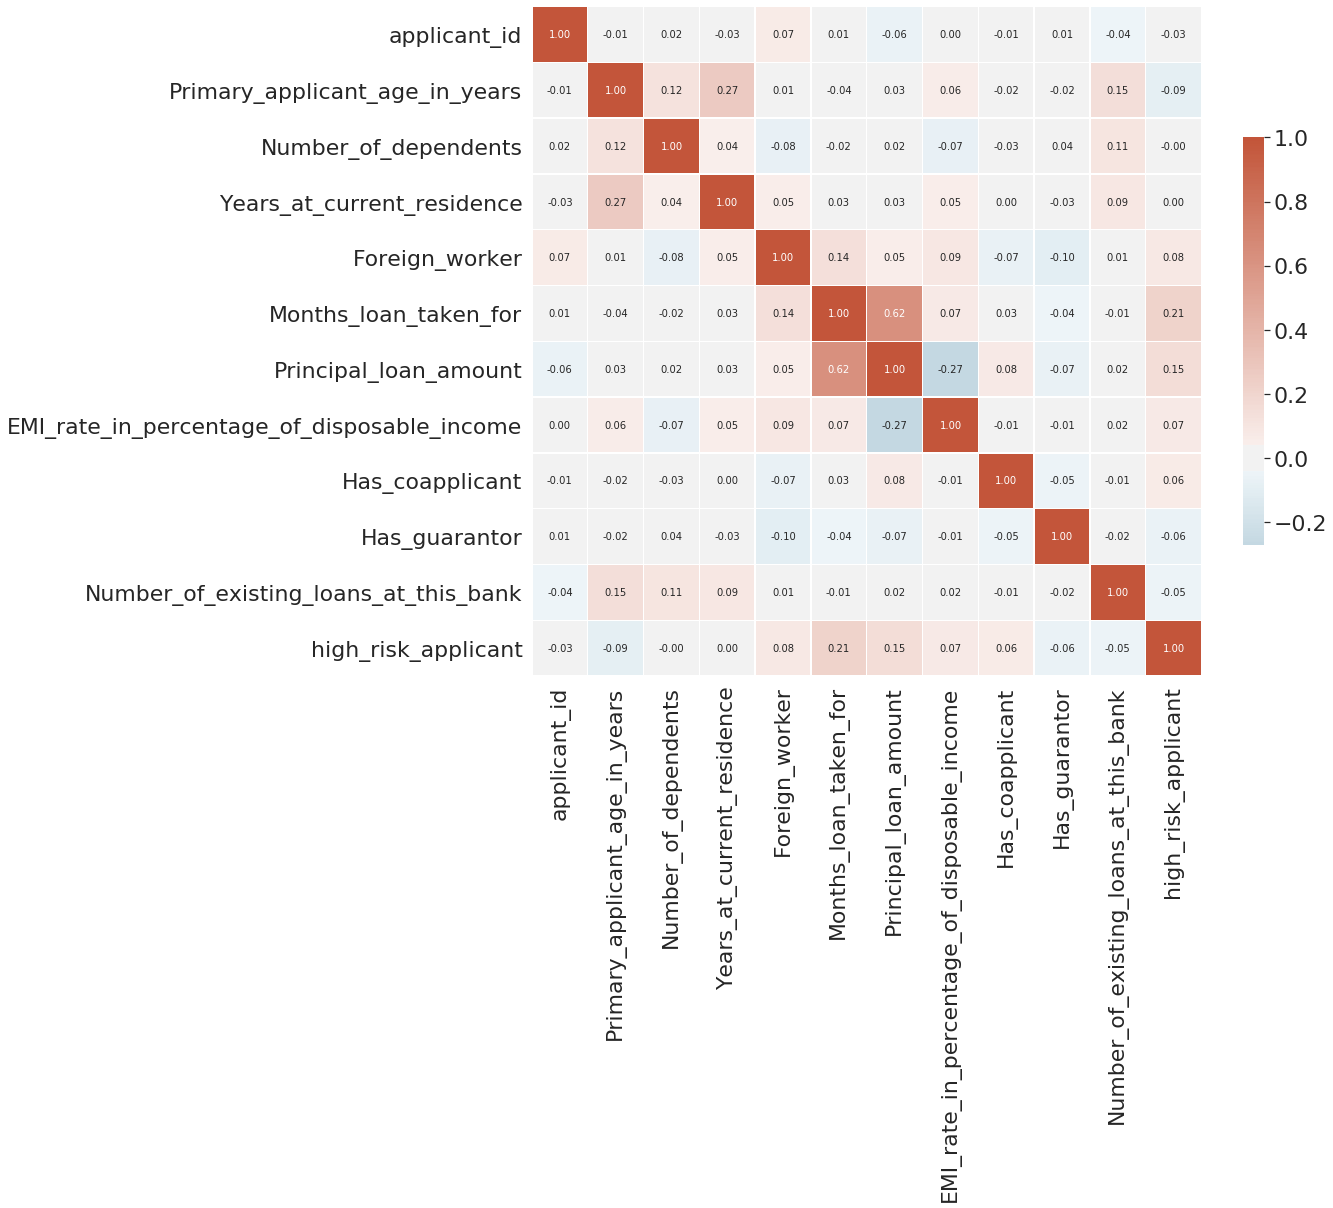

In [42]:
correlation_matrix = applicant_loan.corr()
# Setting the dimensions of the heatmap
plt.subplots(figsize=(15, 15))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(correlation_matrix, cmap=cmap, center=0, fmt=".2f", annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Shuffle and Split Data

Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [43]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(applicant_loan_v2, 
                                                    applicant_risk, 
                                                    test_size = 0.2, 
                                                    random_state = 0)



# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 800 samples.
Testing set has 200 samples.


# How to evaluate model performance?
<a id='evaluate'></a>

 Note that it is worse to state an applicant as a low credit risk when they are actually a high risk, than it is to state an applicant to be a high credit risk when they aren’t. That means taking into account false negatives is more important then keeping track of false positives. Where false positive is stating a low risk applicant as high risk and false negative is stating a high risk applicant as low risk.
 
At first we would think we need to keep track of recall:

[True Positives/(True Positives + False Negatives)]

But there is a problem:

If we were to use the performance of naive predictor as baseline for this project as follows:

1. If the predictor always predicted '1' that the applicant is always high risk. In this case we will have no false negatives or true negatives, as we are not making any negative prediction. So our accuracy and precision will be same. And recall would be set to 1 as we have no False Negatives.

2. And if the predictor always predicted '0' that the applicant is always low risk. In this case we will have no false positives or true postives, as we are not making any positive prediction. So our accuracy and recall would be 0 and precision will 0/0.

So to get any valid results, we will have to make the baseline predictor always predict '1' and use a combination of recall and precision which is f-beta and aprt from that we will also use recall score to evaluate our models.

In [90]:
TP = int(np.sum(applicant_risk)) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
# encoded to numerical values done in the data preprocessing step.
FP = int(len(applicant_risk)) - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = TP/len(applicant_risk)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
# print(type(accuracy),type(recall),type(precision))

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+pow(0.5,2))*(precision*recall)/((pow(0.5,2)*precision)+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}, recall: {:.4f}]".format(accuracy, fscore, recall))


Naive Predictor: [Accuracy score: 0.3000, F-score: 0.3488, recall: 1.0000]


In [95]:
from sklearn.metrics import fbeta_score, accuracy_score, recall_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = start - end
#     print(y_train.shape,predictions_train.shape)
    # Compute accuracy on the  training samples
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=0.2)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.2)
    
    # Compute recall-score on the the training samples using fbeta_score()
    results['r_train'] = recall_score(y_train, predictions_train)
        
    # Compute recall-score on the test set which is y_test
    results['r_test'] = recall_score(y_test, predictions_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [100]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches

def evaluate(results, accuracy, f1, recall):
    """
    Visualization code to display results of various learners.

    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """

    # Create figure
    fig, ax = pl.subplots(2, 4, figsize=(20, 12))

    # Constants
    bar_width = 0.1
    colors = ["#FFF933", "#FF4C33", "#33FF42", "#33B5FF", "#AC33FF"]

    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(
            ["train_time", "acc_train", "f_train","r_train", "pred_time", "acc_test", "f_test", "r_test"]
        ):
            for i in np.arange(3):
                # print(k, j, i)
                # Creative plot code
                ax[j // 4, j % 4].bar(
                    i + k * bar_width,
                    results[learner][i][metric],
                    width=bar_width,
                    color=colors[k],
                )
                ax[j // 4, j % 4].set_xticks([0.45, 1.45, 2.45])
                ax[j // 4, j % 4].set_xticklabels(["1%", "10%", "100%"])
                ax[j // 4, j % 4].set_xlabel("Training Set Size")
                ax[j // 4, j % 4].set_xlim((-0.1, 3.0))

    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)", fontsize=10)
    ax[0, 1].set_ylabel("Accuracy Score", fontsize=10)
    ax[0, 2].set_ylabel("F-score", fontsize=10)
    ax[0, 3].set_ylabel("Recall-score", fontsize=10)
    ax[1, 0].set_ylabel("Time (in seconds)", fontsize=10)
    ax[1, 1].set_ylabel("Accuracy Score", fontsize=10)
    ax[1, 2].set_ylabel("F-score", fontsize=10)
    ax[1, 3].set_ylabel("Recall-score", fontsize=10)

    # Add titles
    ax[0, 0].set_title("Model Training", fontsize=10)
    ax[0, 1].set_title("Accuracy Score on Training Subset", fontsize=10)
    ax[0, 2].set_title("F-score on Training Subset", fontsize=10)
    ax[0, 3].set_title("Recall-score on Training Subset", fontsize=10)
    ax[1, 0].set_title("Model Predicting", fontsize=10)
    ax[1, 1].set_title("Accuracy Score on Testing Set", fontsize=10)
    ax[1, 2].set_title("F-score on Testing Set", fontsize=10)
    ax[1, 3].set_title("R-score on Testing Set", fontsize=10)

    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(
        y=accuracy, xmin=-0.1, xmax=3.0, linewidth=1, color="k", linestyle="dashed"
    )
    ax[1, 1].axhline(
        y=accuracy, xmin=-0.1, xmax=3.0, linewidth=1, color="k", linestyle="dashed"
    )
    ax[0, 2].axhline(
        y=f1, xmin=-0.1, xmax=3.0, linewidth=1, color="k", linestyle="dashed"
    )
    ax[1, 2].axhline(
        y=f1, xmin=-0.1, xmax=3.0, linewidth=1, color="k", linestyle="dashed"
    )
    ax[0, 3].axhline(
        y=recall, xmin=-0.1, xmax=3.0, linewidth=1, color="k", linestyle="dashed"
    )
    ax[1, 3].axhline(
        y=recall, xmin=-0.1, xmax=3.0, linewidth=1, color="k", linestyle="dashed"
    )

    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1.1))
    ax[0, 2].set_ylim((0, 1.1))
    ax[0, 3].set_ylim((0, 1.1))
    ax[1, 1].set_ylim((0, 1.1))
    ax[1, 2].set_ylim((0, 1.1))
    ax[1, 3].set_ylim((0, 1.1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color=colors[i], label=learner))
    pl.legend(
        handles=patches,
        bbox_to_anchor=(-0.80, 2.53),
        loc="upper center",
        borderaxespad=0.0,
        ncol=3,
        fontsize="medium",
    )

    # Aesthetics
    pl.suptitle(
        "Performance Metrics for Three Supervised Learning Models",
        fontsize=10,
        x=0.63,
        y=1.05,
    )
    # Tune the subplot layout
    # Refer - https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots_adjust.html for more details on the arguments
    pl.subplots_adjust(
        left=0.125, right=1.2, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3
    )
    pl.tight_layout()
    pl.show()

# Train the 5 models on different sample sizes of the training set
<a id='train_models'></a>

SVC trained on 8 samples.
SVC trained on 80 samples.
SVC trained on 800 samples.
RandomForestClassifier trained on 8 samples.
RandomForestClassifier trained on 80 samples.
RandomForestClassifier trained on 800 samples.
GradientBoostingClassifier trained on 8 samples.
GradientBoostingClassifier trained on 80 samples.
GradientBoostingClassifier trained on 800 samples.
AdaBoostClassifier trained on 8 samples.
AdaBoostClassifier trained on 80 samples.
AdaBoostClassifier trained on 800 samples.
GaussianNB trained on 8 samples.
GaussianNB trained on 80 samples.
GaussianNB trained on 800 samples.


/home/rohit/anaconda3/envs/EEG/lib/python3.6/site-packages/ipykernel_launcher.py:114: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


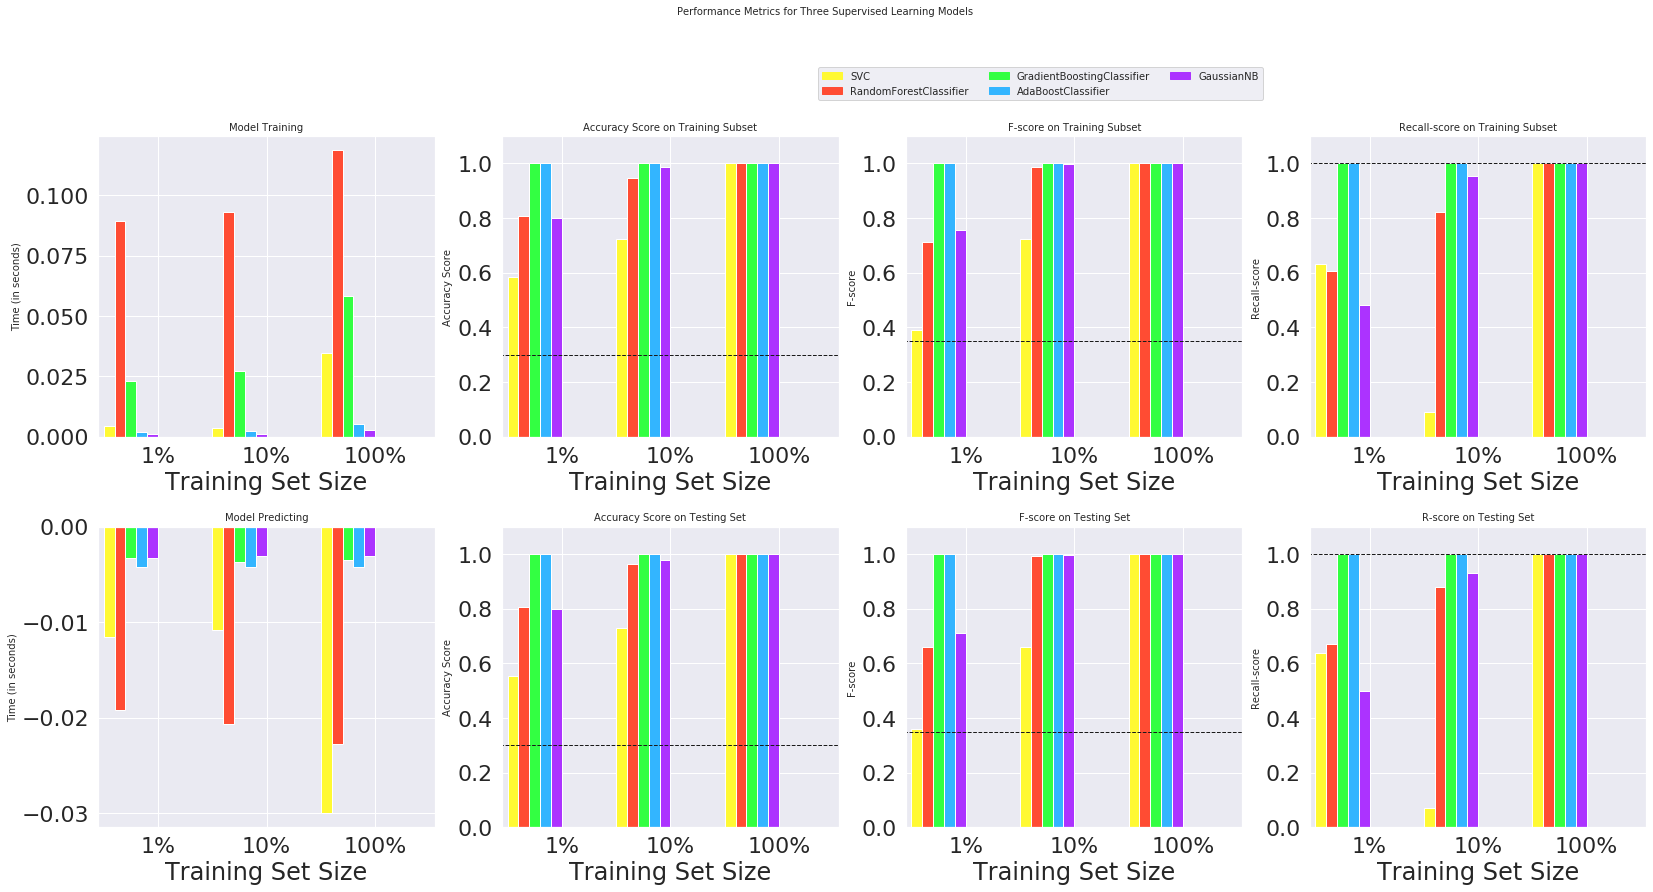

In [101]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from time import time

# Initialize the three models
clf_A = SVC(random_state=10)
clf_B_A = RandomForestClassifier(random_state=10)
clf_B_B = GradientBoostingClassifier(random_state=10)
clf_B_C = AdaBoostClassifier(random_state=10)
clf_C = GaussianNB()

# Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B_A, clf_B_B, clf_B_C, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
# print(results)
# Run metrics visualization for the Five supervised learning models chosen
evaluate(results, accuracy, fscore, recall)


## Observation on how the models performed:

There are 2 sets of 4 plots here. One set is for training preformance and other is for testing performance.
The graph on the left is the training and predicting time of each model. The 2nd, 3rd and 4th graph is the performance of the models in terms of accuracy, f-1 and recall score respectively. And each of the above graphs has the perfornce of the models which have been trained on training set of different size(1%, 10%, 100%).

In terms of training time, random forest took the most time, then came SVC and the least time was taken by XGBoost and Adaboosting models.This would not have been the case if the data points were above a certain limit, because SVM has a much worse time complexity as compared to other algorithms. Refer to [this](https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770).

The reason for training on different sample sizes is that the variance of the original data was totally capured by all the models and every model gave a perfect score on both training and test set. So we needed a set that could help distinguish which model is best in terms of performance. And I believe in this case the best model would be able to give the best f1-score and the least false negatives with the least amount of training data. As we can clearly see that XGBoost and Adaboost classifiers give the best performance. with perfect F1 and recall scoree even with 1% and 10% of the original number of data points.

From the above observations of performance, training and predction times we can easily infer that Adaboost or XGboost would be the way to go.

# Model Tuning
<a id='fine_tune'></a>

Even the model was perfect and did not need any fine tuning i'll do it to discuss the benifits of XGB.

Gradient boosting is a technique attracting attention for its prediction speed and accuracy, especially with large and complex data.

Machine learning models can be fitted to data individually, or combined in an ensemble. Gradient boosing is an ensemble model where a combination of simple individual models that together create a more powerful new model.

Ensemble of models can be created in numerous ways, in case of gradient boosting, boosting is a method for creating an ensemble. It starts by fitting an initial model (in our case its a decision tree) to the data. Then a second model is built that focuses on accurately predicting the cases where the first model performs poorly. The combination of these two models is expected to be better than either model alone. Then you repeat this process of boosting many times. Each successive model attempts to correct for the shortcomings of the combined boosted ensemble of all previous models.

The reason it performs better then its siblings adaboost and random forest algorithms is because it embodies their advantages in its own implementation. That is, its has the abitily to control the learning rate(shrikage introduced in adaboost) and feature subsampling(introduced in random forest) which helps reduce overfitting.

references:

[Gradient Boosting Explained – The Coolest Kid on The Machine Learning Block](https://www.displayr.com/gradient-boosting-the-coolest-kid-on-the-machine-learning-block/#:~:text=Gradient%20boosting%20is%20a%20type,order%20to%20minimize%20the%20error.)

[The Ultimate Guide to AdaBoost, random forests and XGBoost](https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f)

So the hyperparameters i chose for imporving the model performance was same as decision tree which is max_depth. And other parameter was number of estimator to create a better ensemble to improve generalization.

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score, fbeta_score, confusion_matrix
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=10)

# Create the parameters list you wish to tune, using a dictionary if needed.

parameters = {
              'max_depth' : [3,5,7],
              'n_estimators' :[25,50,150],
              'min_samples_split' : [3,4,5]
              }
# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, n_jobs=10)

In [105]:
# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("confusion matrix on testing data: {}".format(confusion_matrix(y_test,predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("Final confusion matrix on testing data: {}".format(confusion_matrix(y_test,best_predictions)))

Unoptimized model
------
Accuracy score on testing data: 1.0000
F-score on testing data: 1.0000
confusion matrix on testing data: [[142   0]
 [  0  58]]

Optimized Model
------
Final accuracy score on the testing data: 1.0000
Final F-score on the testing data: 1.0000
Final confusion matrix on testing data: [[142   0]
 [  0  58]]


# Questions and answers for 7 - 11:

7. **Which ML algorithm you plan to use for modeling.**

Instead of giving 2 models I have considered 5 models:
1. SVM
2. NB
3. Random forest classifier
4. Adaboost classifier
5. XGB

I wanted to test the performance of all the tree-based ensemble models(random forest, adaboost, gradientboost) on this problem, and do a comparitive analysis in terms of training, testing time and performance wise.
I thought it would be interesting to check how slow SVM would be to these other algorithms.
Although Naive Bayes is mostly used in text classification and has an assumption that the features should be independent. It has still shown some good results on other problems link. So i thought it would be intersting to see whether we can make a speed vs performance trade of between SVM and Naive bayes.

8. **Train two (at least) ML models to predict the credit risk & provide the confusion matrix for each model.**

Refer to [this](#train_models)

9. **How you will select the hyperparameters for models trained in above step.**

Refer to [this](#fine_tune)

10. **Which metric(s) you will choose to select between the set of models.**

Refer to [this](#evaluate)

11. **Explain how you will export the trained models & deploy it for prediction in production**

A model which is used to classify the loan creditworthyness of an applicant can mostly be used in two scenarios:
1. B2B
2. B2C

Well B2B or B2C might not be the correct terms for it but let me explain to make it more clear. 

In B2B the applicats or customer profiles would be in bulk and the prediction would be made in batches, where as in B2C the predictions would be made made on an on-demand basis. We would need a low latency when it comes to B2C or on-demand predicitons. 

For batch based predictions the optimizations would be made to minimize compute cost and an offline model would also suffice, since the predictions are not needed immedietly. The change in data with time can be easily handled with by just making regular monitoring of the metric on rolling test sets and if the metric falls below a certain limit, its time to retrain the model, and there would be no risk of providing wrong predictions since the predicitons are done in batches and are not immedietly needed.

For on-demand prediction the optimizations would be made to reduce maintainance cost, usually API calls would be made or the model will be deployed as web service with flask as a wrapper and the customer can input their details and get wether they fullfill the requirements for the loan and can be approved for it. In such cases if the data distribution changes due to market change there is a risk of giving wrong predictions. One way to deal with this problem is to have a mechanisim to periodically retrain the model but this can be really expensive as there might be chances where the model is performing fine but still schedule retraining is initiated. Other way is to have a model with comparitively low variance, which will not perform as good as the high variance models but would not need retraining as much as the other model. 